In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

df = pd.read_excel('축산유통정보_한우돼지도매가격_일범_230102.xlsx', sheet_name='돼지_도매가격')

In [3]:
def trend(x):
    if re.search('▼', x):
        symbol = -1
    elif re.search('▲', x):
        symbol = 1
    else:
        return np.nan

    x = re.split('▼|▲', x)[1]
    x= re.sub(',|-| ', '', x)

    return float(x) * symbol

df = df.iloc[3:, :2]
df.columns = ['date', 'price']

df['trend'] = df['price'].apply(trend)
df['price'] = df['price'].apply(lambda x: re.split('▼|▲', x)[0] if re.search('▼|▲', x) else x)

df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='date', inplace=True)
df.dropna(inplace=True)

df['price'] = df['price'].apply(lambda x: re.sub(',|-| ', '', x))
df['price'] = df['price'].astype(float)

df.index = range(len(df))

In [4]:
df

,date,price,trend
0,2011-01-04,4776.0,137.0
1,2011-01-05,4749.0,-27.0
2,2011-01-06,4884.0,135.0
3,2011-01-07,4960.0,76.0
4,2011-01-10,5040.0,80.0
...,...,...,...
2960,2022-12-23,5374.0,-282.0
2961,2022-12-27,5624.0,-34.0
2962,2022-12-28,5629.0,5.0
2963,2022-12-29,5525.0,-104.0


# Train and test

,date,price,trend,price_lead_1
0,2011-01-04,4776.0,137.0,4749.0
1,2011-01-05,4749.0,-27.0,4884.0
2,2011-01-06,4884.0,135.0,4960.0
3,2011-01-07,4960.0,76.0,5040.0
4,2011-01-10,5040.0,80.0,5215.0
...,...,...,...,...
2959,2022-12-22,5656.0,-134.0,5374.0
2960,2022-12-23,5374.0,-282.0,5624.0
2961,2022-12-27,5624.0,-34.0,5629.0
2962,2022-12-28,5629.0,5.0,5525.0


r2:  0.9340086975365387
MAE:  162.74940758395365


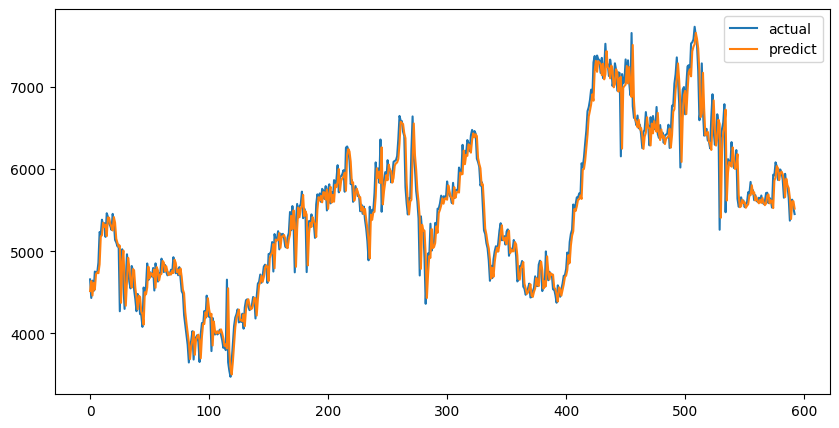

In [5]:
# auto arima
from pmdarima.arima import auto_arima

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


data = df.copy()
data['price_lead_1'] = data['price'].shift(-1)
data.dropna(inplace=True)

display(data)

X_train, X_test, y_train, y_test = train_test_split(data[['price', 'trend']], data['price_lead_1'], test_size=0.2, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

# predict
pred = model.predict(X_test)

# eval
print('r2: ', r2_score(y_test, pred))
print('MAE: ', mean_absolute_error(y_test, pred))

# visualize
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='actual')
plt.plot(pred, label='predict')
plt.legend()
plt.show()

# Predict

In [68]:
from pmdarima.arima import auto_arima

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from datetime import timedelta
from datetime import datetime
import optuna

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

# Ensemble model

<AxesSubplot:xlabel='date'>

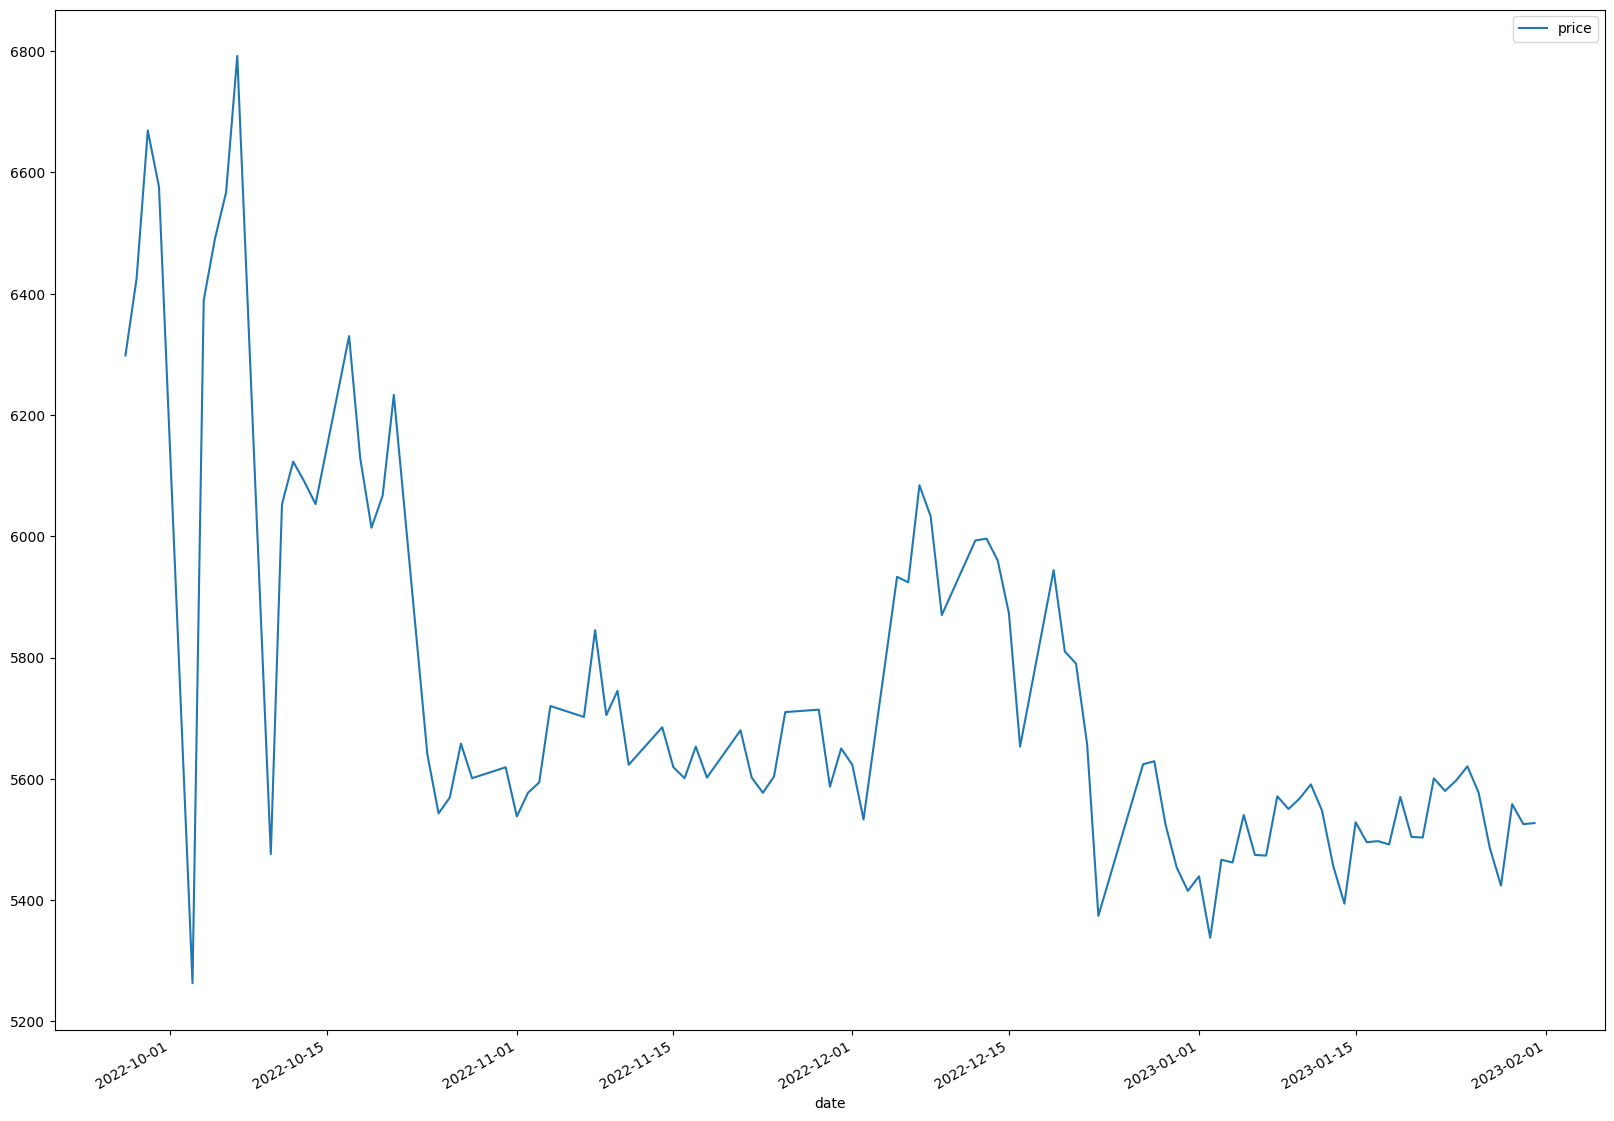

In [139]:
data = df[df['date'] >= '2018-01-1'].copy()
data_cp = df[df['date'] >= '2018-01-1'].copy()

data['price_lead_1'] = data['price'].shift(-1)
data['trend_lead_1'] = data['trend'].shift(-1)

data.dropna(inplace=True)

train_X, train_y = data[['trend']].values, data['trend_lead_1'].values

end_date = datetime.strptime('2023-01-31', '%Y-%m-%d')

# def GB_objective(trial):
#     max_depth = trial.suggest_int('max_depth', 1, 10)
#     max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 50)
#     n_estimators =  trial.suggest_int('n_estimators', 10, 300)
   
#     model = GradientBoostingRegressor(
#         max_depth = max_depth, 
#         max_leaf_nodes = max_leaf_nodes, 
#         n_estimators = n_estimators, 
#         random_state=25
#     )
#     model.fit(train_X, train_y)

#     train_pred = model.predict(train_X)
    
#     return r2_score(train_y, train_pred)
    
# #Execute optuna and set hyperparameters
# RF_study = optuna.create_study(direction='maximize', )
# RF_study.optimize(GB_objective, n_trials=30)

# {'max_depth': 10, 'max_leaf_nodes': 33, 'n_estimators': 271}

# optimized_GB = GradientBoostingRegressor(
#     max_depth = RF_study.best_params['max_depth'], 
#     max_leaf_nodes = RF_study.best_params['max_leaf_nodes'],
#     n_estimators = RF_study.best_params['n_estimators'],
#     random_state=25
# )
optimized_GB = GradientBoostingRegressor(
    max_depth = 10, 
    max_leaf_nodes = 33,
    n_estimators = 271,
    random_state=25
)
optimized_GB.fit(train_X, train_y)

while data_cp.iloc[-1].date < end_date:
    last_row = data_cp.iloc[-1]

    # new_prediction = model.predict(data_cp[['trend']].iloc[[-1]].values).item()
    new_trend = optimized_GB.predict(data_cp[['trend']].iloc[[-1]].values).item()
    
    new_date  = last_row.date + timedelta(days=1)
    new_row = [
        new_date,
        last_row.price + new_trend,
        new_trend,
    ]

    # concate new row to data_cp, and keep index in order
    data_cp = pd.concat([data_cp, pd.DataFrame([new_row], columns=['date', 'price', 'trend'])], ignore_index=True)

data_cp[-100:].plot(x='date', y='price', figsize=(20, 15))

In [135]:
data_cp[data_cp['date'] >= '2023-01-01'].to_clipboard(index=False)

# ARIMA

In [92]:
from statsmodels.tsa.arima.model import ARIMA

data = df.copy() # [df['date'] > '2018-01-01']
data_cp = df.copy() # [df['date'] > '2018-01-01']

end_date = datetime.strptime('2023-01-31', '%Y-%m-%d')

while data_cp.iloc[-1].date < end_date:
    y = data_cp['price'].values
    last_row = data_cp.iloc[-1]

    SARIMA_model = auto_arima(y, error_action='ignore', suppress_warnings=True, stepwise=False, seasonal=False)
    model = ARIMA(y, order=SARIMA_model.order).fit()

    new_prediction = model.forecast(1).item()
    
    new_date  = last_row.date + timedelta(days=1)
    new_row = [
        new_date,
        new_prediction,
        last_row.price - new_prediction,
    ]

    # concate new row to data_cp, and keep index in order
    data_cp = pd.concat([data_cp, pd.DataFrame([new_row], columns=['date', 'price', 'trend'])], ignore_index=True)

<AxesSubplot:xlabel='date'>

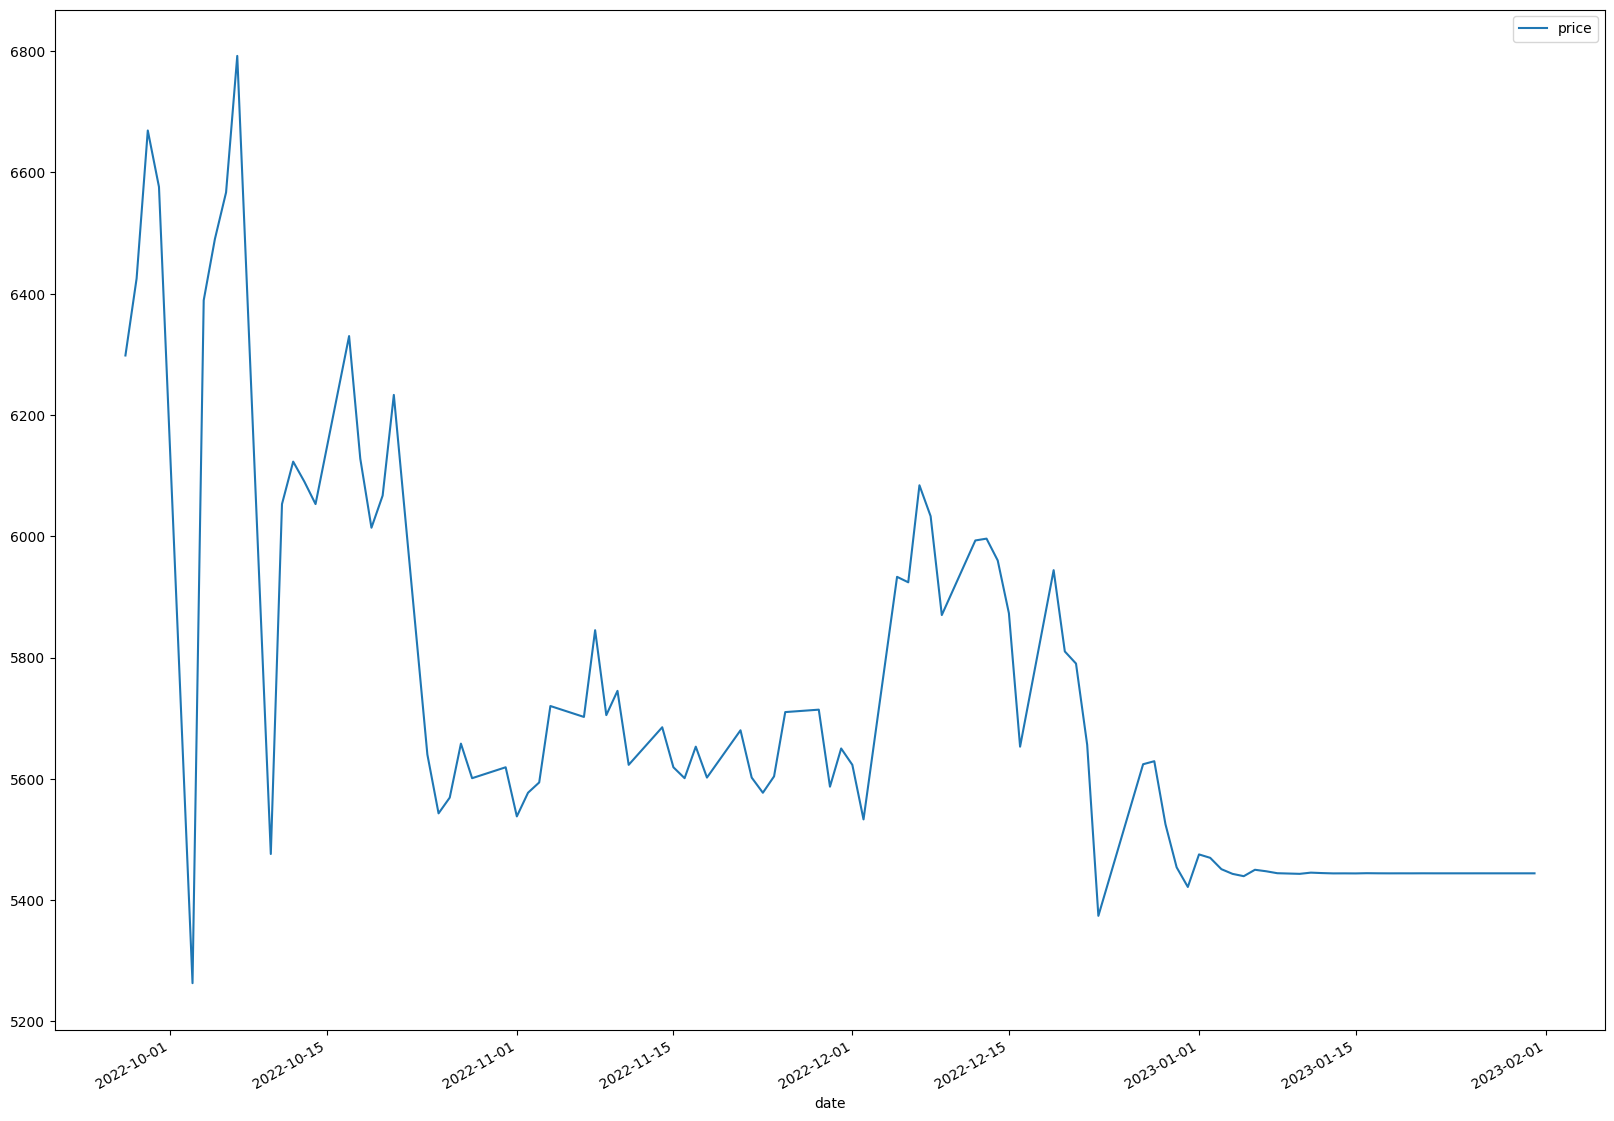

In [94]:
data_cp[-100:].plot(x='date', y='price', figsize=(20, 15))

# neural network